<a href="https://colab.research.google.com/github/daichi-a/PythonDataAnalyzeClassMaterial/blob/master/ChoiceBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

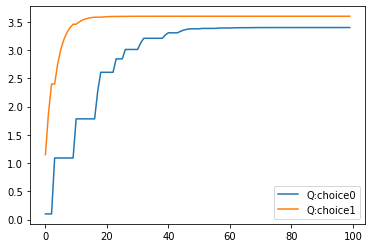

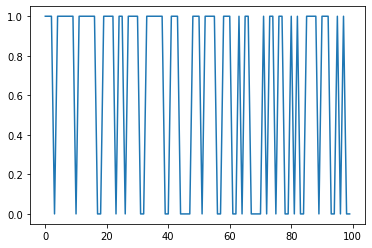

In [1]:
# 過程を生成するためのQ学習
import numpy as np
import random
import math

num_of_trial = 100
num_of_choice = 2

# 現在のQ値を保持する．状態は常に同じ選択肢は常に同じものが2
Q = np.zeros((num_of_choice), dtype=np.float)

# ベイズ推定のために選択肢を記録する
choice_array = np.zeros((num_of_trial), dtype=np.int)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
Qpast = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

#Qの初期値．両方とも同じに設定する
Q[0] = 0.1
Q[1] = 0.1

Qpast[0][0] = Q[0]
Qpast[0][1] = Q[1]

# その時点での選択確率を記録する配列
p_choice_array = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

# 報酬は，選択肢0の時は常に1.0, 選択肢1の時は常に1.2
rewards = np.array([1.0, 1.2], dtype=np.float)

# 学習率アルファ
learning_rate = 0.3

# 減衰割引率ガンマ
decay_discount_factor = 2.0

# 選択方法
choice_algorithm = 'Softmax'

# Softmaxの逆温度
inverse_temperature = 1.0

for t in range(0, num_of_trial, 1):
  # 現在の試行回数がtに入る
  if choice_algorithm == 'Roulette':
    # ルーレット方式で選択肢を決定する　（一般的にはε-グリーディ法を使うので，ちょっと違うが，わかりやすくするため）
    # 現在のQ値のルーレットを作成
    sumQ = np.sum(Q)
    roulette_number = random.random() * sumQ
    if roulette_number < Q[0]:
      current_choice = 0
    else:
      current_choice = 1
  else:
    # Softmaxで行動を選択する
    p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
    deno = 0.0
    for i in range(num_of_choice):
      # Softmaxの分母部分の計算
      deno += math.exp(inverse_temperature * Q[i])
    for i in range(num_of_choice): # 現在の状態において2つの選択を取る確率をそれぞれ計算
      p_choice_array[t][i] = p_choice_sm[i] = math.exp(inverse_temperature * Q[i]) / deno


    # 乱数を振ってどの選択か決める
    softmax_num = random.random()
    current_choice = num_of_choice - 1
    sum_p = 0.0
    for i in range(num_of_choice-1):
      sum_p += p_choice_sm[i]
      if softmax_num < sum_p:
        current_choice = i
        break

    if current_choice == 0:
      # 選択肢0が選ばれた
      current_rewards = rewards[0]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ0 = Q[0] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[0])
      # 選択肢0のQ値を更新
      Qpast[t][0] = Q[0] = nextQ0
      # 選択肢1のQ値は変わらない
      Qpast[t][1] = Q[1]

    else:
      # 選択肢1が選ばれた
      current_rewards = rewards[1]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ1 = Q[1] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[1])
      # 選択肢1のQ値を更新
      Qpast[t][1] = Q[1] = nextQ1
      # 選択肢0のQ値は変わらない
      Qpast[t][0] = Q[0]

  choice_array[t] = current_choice

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trial, 1)]).ravel()
# 描画のために選択肢0と1の系列を引っ張り出すため，transposeで次元をひっくり返す
Qpast = Qpast.transpose()
plt.plot(x_array, Qpast[0].ravel(), label='Q:choice0')
plt.plot(x_array, Qpast[1].ravel(), label='Q:choice1')

plt.legend()
plt.show()
# あっという間に収束する


plt.plot(x_array, choice_array, label='Choice')
plt.show()

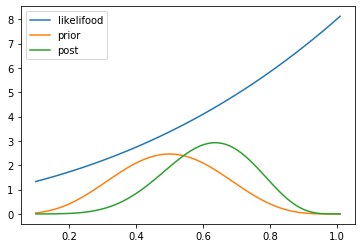

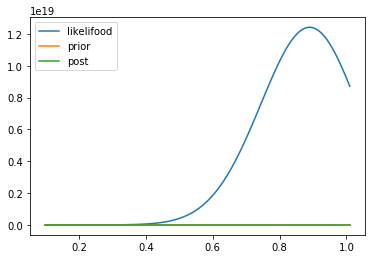

In [24]:
# まずは，尤度関数，事前分布，事後分布をそれぞれプロットしてみる

# https://github.com/kkatahira/cmbd-book/blob/master/chapter4/Bernoulli_bayes.R
# を参考に

import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

# 0もしくは1のベイズ推定
# 要するに，0か1が出る確率……本来なら0.5, 0.5だが，これを結果から逆算していく

# 試行データ
# コイントスで3回連続表が出た，とする
data = np.array([1, 1, 1], dtype=np.int)

# 試行データとして，Q学習の選択過程を用いる
# data = choice_array

# ベイズ推定に用いる関数の設定
# 事前分布 (ベータ分布) のハイパーパラメータの設定
a = 5
b = 5

# 尤度関数の定義　 (muはオモテが出る確率で，これを0~1.0まで動かしてみて結果を描画する)
def likelifood(mu, data):
  likelifood_array = np.zeros(len(mu), dtype=np.float)
  C1 = np.sum(data) # 1の数
  C0 = len(data) - C1 # 0の数
  return np.array([math.exp(C1 * math.log1p(p) + C0 * math.log1p(1.0 - p)) for p in mu])

# 事前分布 (ベータ分布) 確率密度関数
def prior(mu, a, b):
  return scipy.stats.beta.pdf(mu, a, b)
  # dbeta はパラメータ shape1, shape2 (そしてオプションの非心度パラメータ ncp) を持つベータ分布の密度関数


# 事後確率密度
def posterior(mu, data, a, b):
  C1  =  np.sum(data)   # 1を数える
  C0  = len(data) - C1 # 0を数える
  return scipy.stats.beta.pdf(mu, a+C1, b+C0)
 
plot_range = np.linspace(0.1, 1.01, 100)
likelifood_array = likelifood(plot_range, data)
prior_distribution = prior(plot_range, a, b)
posterior_distribution = posterior(plot_range, data, a, b)

# plt.plot(plot_range, np.log1p(plot_range))

plt.plot(plot_range, likelifood_array, label='likelifood')
plt.plot(plot_range, prior_distribution, label='prior')
plt.plot(plot_range, posterior_distribution, label='post')
plt.legend()
plt.show()

plot_range = np.linspace(0.1, 1.01, 100)
plt.plot(plot_range, likelifood(plot_range, choice_array), label='likelifood')
prior_distribution = prior(plot_range, a, b)
plt.plot(plot_range, prior_distribution, label='prior')
posterior_distribution = posterior(plot_range, choice_array, a, b)
plt.plot(plot_range, posterior_distribution, label='post')
plt.legend()
plt.show()

In [0]:
# 今度はMAP推定で，試行データから，Q学習のαとβを推定する
# MAPとはmaximum a postriori 最大事後確率のこと
# 推定したい量の事前分布を利用して数値最適化問題を解き，確率が最大のものを使用する

# https://github.com/kkatahira/cmbd-book/blob/master/chapter4/qlearning_simulation_Bayes_single.R
# を参考に

# Softmaxを使ったQ学習のモデル関数
# これは前と同じ
def func_qlearning(param, data, prior=None):
  alpha =  param[1]
  beta =  param[2]
  choice = data[0] # 行動選択の履歴のデータ
  rewards = data[1] # 報酬の配列
  T = len(c)
  p_choice = np.zeros((T), dtype=np.float) #試行tで0を選択する確率．1を選択する確率は1 - p_choice[t]になる

  Q = np.zeros((T, 2), dtype=np.float) # Q値を記録する配列（選択肢0と選択肢1について，それぞれ試行回数）
  Q[0][0] = 0.001
  Q[0][1] = 0.001 # 最初の選択のために初期化しておく

  log_l = 0 # 対数尤度 log_likelifood

  # それぞれの選択肢を選択した合計数
  sum_choice0 = np.sum(choice)
  sum_choice1 = T - sum_choice0

  for t in range(T):
    if choice[t] > 0: # 選択肢0を選択した時

      # 選択肢0の選択確率を計算
      p_choice[t] = 1 / ( 1 + math.exp(-1 * beta * (Q[t][0] - Q[t][1])))
      # 対数尤度を計算
      log_l += sum_choice0 * log(p_choice[t]) +  sum_choice1 * log(1 - p_choice[t])

      # Q値を更新
      if t < T:
        Q[t+1][choice[t]] = Q[t][choice[t]] + alpha * (rewards[t] - Q[t][choice[t]] ) 
        Q[t+1][1-choice[t]] = Q[1-choice[t]][t]
      # tがケツで更新しようとするとindexを超えるので，更新しない

  # 対数事後確率密度を求める
  if (prior == None):
      lprior = 0
  else:
    lprior <- dbeta(alpha,prior$alpha_a, prior$alpha_b,log = T) + dgamma(beta,shape=prior$beta_shape, scale=prior$beta_scale,log = T)
    lprior scipy.stats.beta.logpdf


